## Segmentation d'images

<img src="mySaves/other_images/logo_future_vision_transport.png" alt="logo_future_vision_transport" width="400" class="center"/>

# Scrips

## I. Imports

In [1]:
# imports

import tensorflow as tf
import keras
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

import albumentations as A

import os

import numpy as np

import matplotlib.pyplot as plt

import myFunction as mf
%load_ext autoreload
    
%autoreload 2


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")

## II. Accéder au dataset des images : Data Generator

In [3]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [4]:
# define augmentations for training
list_of_transforms = [
    A.HorizontalFlip(p=0.5), 
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=25,
        p=0.5
    ),
    A.RandomCrop(
            height=192,
            width=192*2,
            p=0.5
        ),
    A.PadIfNeeded(
        min_height=256,
        min_width=512,
        p=1
        ),
    A.OneOf(
        [
            A.CLAHE(p=1, clip_limit=6),
            A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=0.5
    ),
    A.OneOf(
        [
            A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            A.Blur(p=1, blur_limit=9),
            A.MotionBlur(p=1, blur_limit=9)
        ],
        p=0.5
    ),
    A.HueSaturationValue(
        p=0.5, 
        hue_shift_limit=120, 
        sat_shift_limit=2, 
        val_shift_limit=100
        )
]

    


# Model UNET Resnet50

In [5]:
cats

{'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [6]:
backbone_name = 'resnet50'
batch_size = 32

train_gen = mf.generator(
    batch_size=batch_size,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="train",
    cats=cats,
    backbone = backbone_name,
    augmentation=A.Compose(list_of_transforms),
    shuffle=True
)

same_random_state = 16
same_test_size = 0.3

valid_gen = mf.generator(
    batch_size=1,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="val",
    cats=cats,
    backbone = backbone_name,
    augmentation=None,
    shuffle=False,
    split=True,
    split_test_size=same_test_size,
    split_keep="split_train",
    split_rs=same_random_state
)

test_gen = mf.generator(
    batch_size=1,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="val",
    cats=cats,
    backbone = backbone_name,
    augmentation=None,
    shuffle=False,
    split=True,
    split_test_size=same_test_size,
    split_keep="split_test",
    split_rs=same_random_state
)

In [7]:
len(valid_gen)

350

In [8]:
len(test_gen)

150

In [9]:
# create folder for saving
if not os.path.isdir("mySaves/models"):
    os.mkdir("mySaves/models")

In [10]:
input_shape = train_gen[0][0][0].shape
classes = len(cats)
activation = "softmax"
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

jaccard = sm.metrics.IOUScore(threshold=0.5)
dice = sm.metrics.FScore()
metrics = [jaccard, dice]


unet_resnet50 = sm.Unet(
    backbone_name=backbone_name,
    input_shape=input_shape,
    classes=classes,
    activation=activation
)

unet_resnet50.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=metrics
)

unet_resnet50.summary()





Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 512, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 518, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                          

In [11]:
reboot = False
continue_fitting = False

In [12]:

if ("resnet50.h5" in os.listdir("mySaves/models")) and reboot == False :
    if reboot == False :
        unet_resnet50.load_weights("mySaves/models/resnet50.h5")

if ("resnet50.h5" not in os.listdir("mySaves/models")) or (reboot == True) or (continue_fitting == True) :

   # define callback
   callbacks = [
      keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=2, mode="max")
   ]
   
   unet_resnet50.fit(
        x=train_gen,
        steps_per_epoch=len(train_gen),
        epochs=100,
        validation_data=valid_gen,
        callbacks=callbacks
    )
   
   unet_resnet50.save_weights("mySaves/models/resnet50.h5")



In [13]:
scores = unet_resnet50.evaluate(test_gen)



150/150 [==============================] - 33s 205ms/step - loss: 0.9350 - iou_score: 0.6218 - f1-score: 0.5965


In [14]:
scores

[0.9350249171257019, 0.6217789649963379, 0.5964867472648621]

In [15]:
def testModel(model, test_gen, n_images, random_state=16) :
    '''
    test a 

    parameters :
    ------------
    gen - generator custom class instance
    trans - list of Albumentations transforms
    idx - int : index in generator "gen"
    trans_name - string : the name of transformation, to put in title. By default : ""
    '''

    # imports 
    import matplotlib.pyplot as plt
    import numpy as np

    np.random.seed(seed=random_state)
    some_examples_idx = np.random.choice(np.arange(len(test_gen)), size = n_images)

    some_examples = [test_gen[i] for i in some_examples_idx]

    some_images = np.array([example[0][0] for example in some_examples])
    some_masks = np.array([example[1][0] for example in some_examples])

    some_masks = np.expand_dims(np.argmax(some_masks, axis=3), axis=3)


    preds = model.predict(some_images)
    preds = np.expand_dims(np.argmax(preds, axis=3), axis=3)

    # create figure
    fig, axs = plt.subplots(n_images,3,figsize=(14,7*n_images/3))

    # imshow and titles
    for i in range(n_images) :
        for j, images_array in enumerate([some_images, some_masks, preds]) :
            axs[i,j].imshow(images_array[i])

            axs[i,j].set_axis_off()
        # axs[i].set_title(title)

    # main title

1/1 [==============================] - 1s 1s/step
(256, 512, 8)
(256, 512, 1)


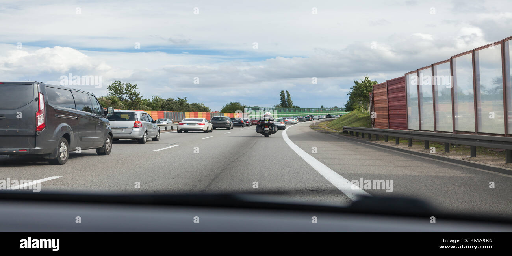

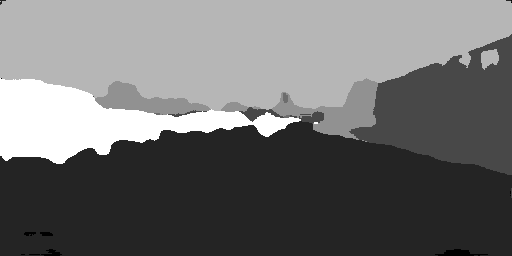

In [16]:
perso = keras.preprocessing.image.load_img("photo-prise-de-l-interieur-de-la-voiture-a-la-route-2e3kacw.jpg",target_size=(256,512))

perso = keras.preprocessing.image.img_to_array(perso)

perso = sm.get_preprocessing(backbone_name)(perso)

perso_pred = unet_resnet50.predict(np.array([perso]))[0]

print(perso_pred.shape)

perso_pred = np.expand_dims(np.argmax(perso_pred, axis=2), axis=2)

print(perso_pred.shape)

display(keras.preprocessing.image.array_to_img(perso))
display(keras.preprocessing.image.array_to_img(perso_pred))

1/1 [==============================] - 2s 2s/step


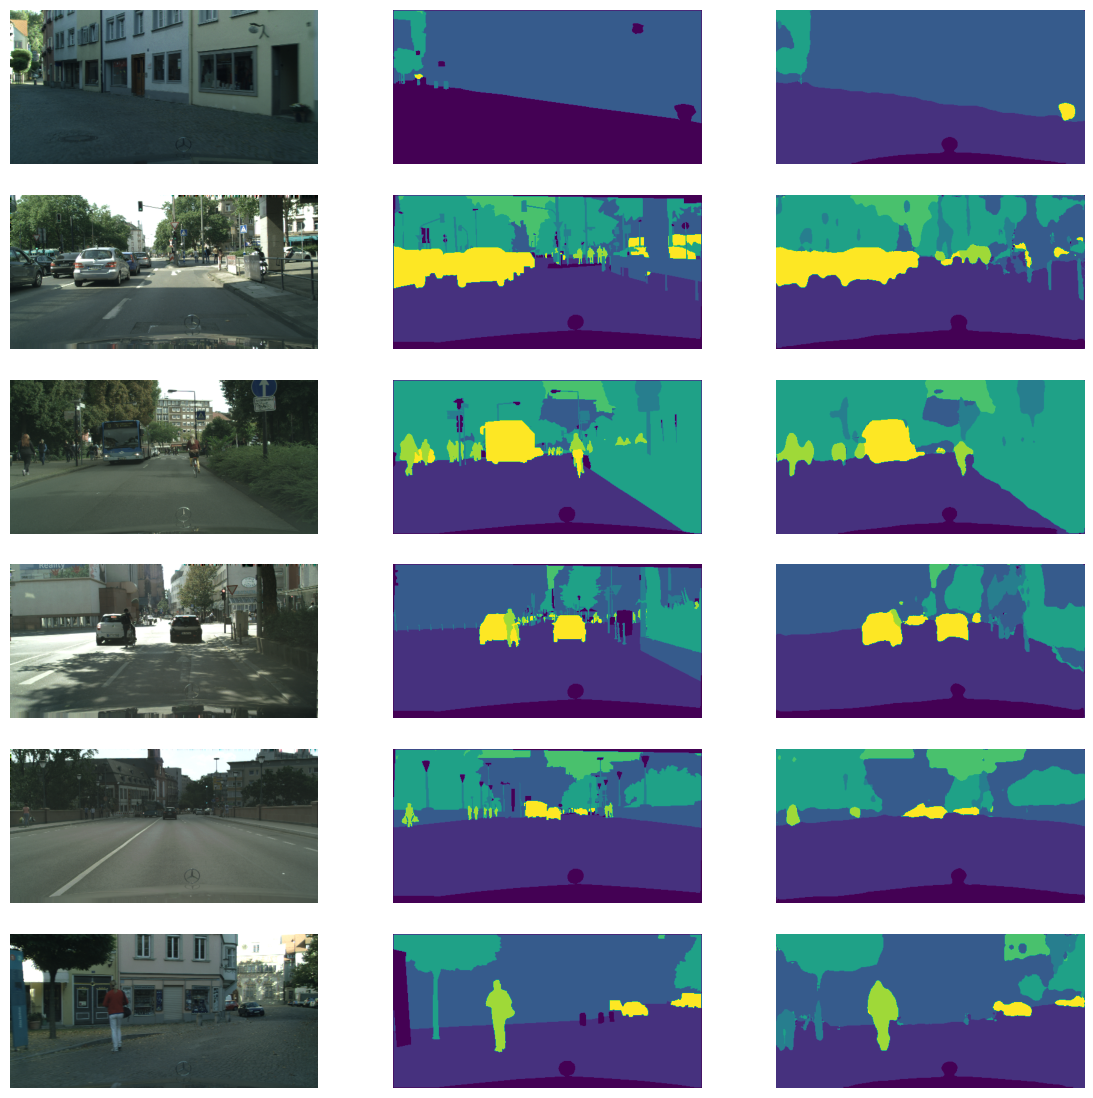

In [17]:
testModel(model=unet_resnet50, test_gen=test_gen, n_images=6, random_state=16)

# Model VGG16

In [18]:
backbone_name = 'vgg16'
batch_size = 32

In [19]:
input_shape = train_gen[0][0][0].shape
classes = len(cats)
activation = "softmax"
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

jaccard = sm.metrics.IOUScore(threshold=0.5)
dice = sm.metrics.FScore()
metrics = [jaccard, dice]


unet_vgg16 = sm.Unet(
    backbone_name=backbone_name,
    input_shape=input_shape,
    classes=classes,
    activation=activation,
)

unet_vgg16.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=metrics
)

unet_vgg16.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [20]:
reboot = False
continue_fitting = False

In [21]:

if ("vgg16.h5" in os.listdir("mySaves/models")) and reboot == False :
    if reboot == False :
        unet_vgg16.load_weights("mySaves/models/vgg16.h5")

if ("vgg16.h5" not in os.listdir("mySaves/models")) or (reboot == True) or (continue_fitting == True) :

   # define callback
   callbacks = [
      keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=2, mode="max")
   ]

   unet_vgg16.fit(
        x=train_gen,
        steps_per_epoch=len(train_gen),
        epochs=100,
        validation_data=valid_gen,
        callbacks=callbacks
    )
   
   unet_vgg16.save_weights("mySaves/models/vgg16.h5")



In [23]:
scores = unet_vgg16.evaluate(test_gen)

150/150 [==============================] - 56s 374ms/step - loss: 0.9838 - iou_score: 0.2352 - f1-score: 0.2984


1/1 [==============================] - 1s 686ms/step
(256, 512, 8)
(256, 512, 1)


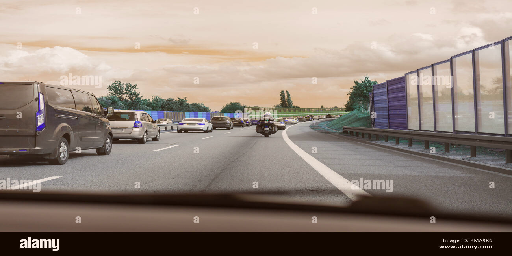

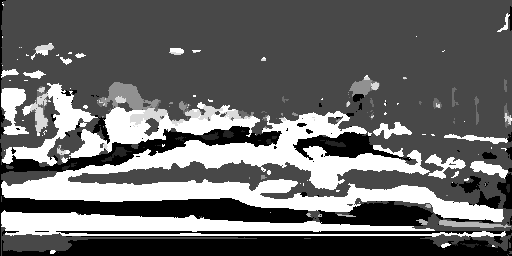

In [24]:
perso = keras.preprocessing.image.load_img("photo-prise-de-l-interieur-de-la-voiture-a-la-route-2e3kacw.jpg",target_size=(256,512))

perso = keras.preprocessing.image.img_to_array(perso)

perso = sm.get_preprocessing(backbone_name)(perso)

perso_pred = unet_vgg16.predict(np.array([perso]))[0]

print(perso_pred.shape)

perso_pred = np.expand_dims(np.argmax(perso_pred, axis=2), axis=2)

print(perso_pred.shape)

display(keras.preprocessing.image.array_to_img(perso))
display(keras.preprocessing.image.array_to_img(perso_pred))

1/1 [==============================] - 2s 2s/step


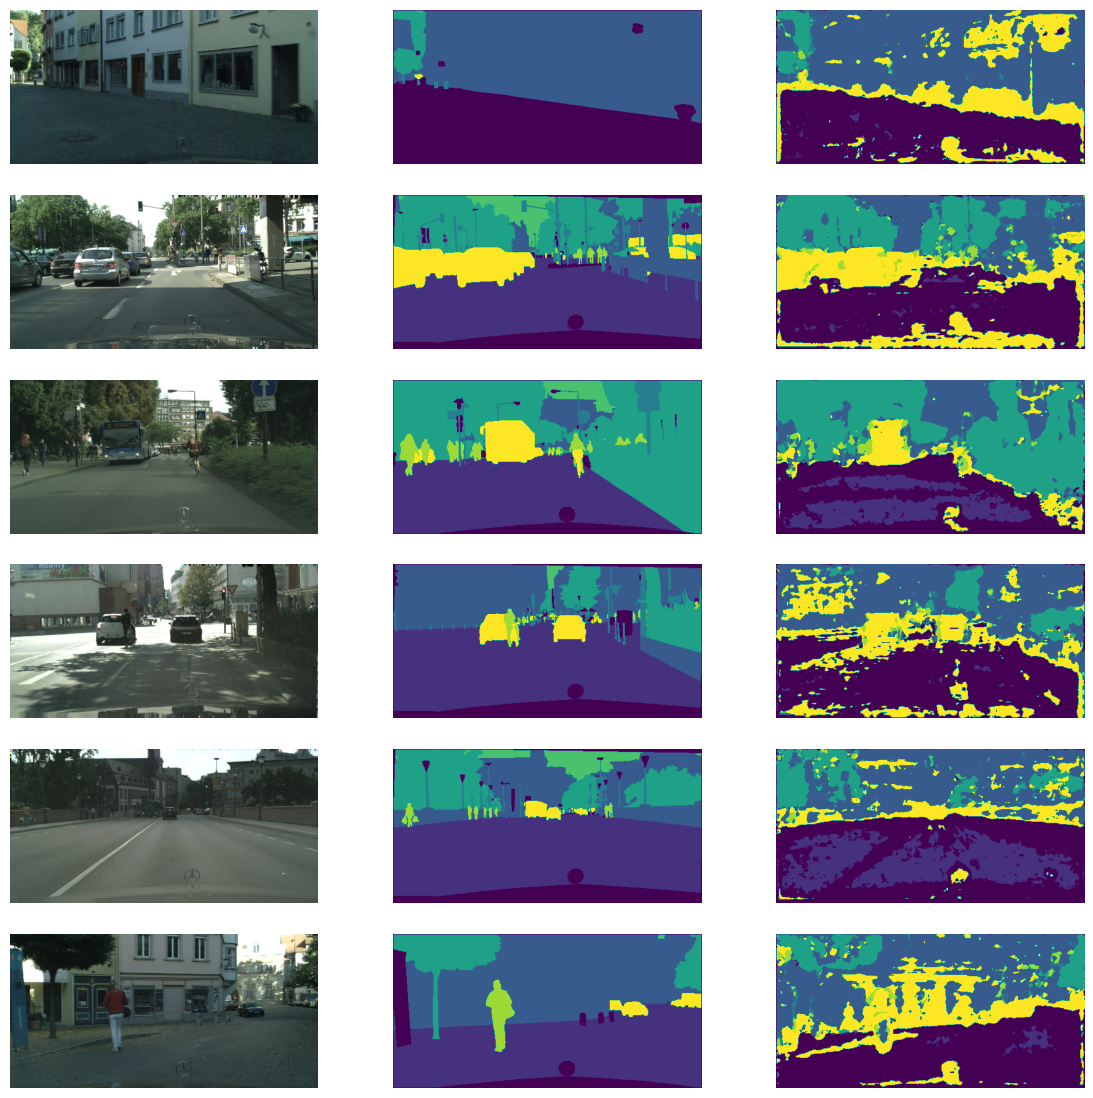

In [25]:
testModel(model=unet_vgg16, test_gen=test_gen, n_images=6, random_state=16)

# Tests aumgentations

In [45]:
raw_gen = mf.generator(
    batch_size=batch_size,
    images_path='P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/', 
    masks_path='P8_Cityscapes_gtFine_trainvaltest/gtFine/',
    image_size=(256, 256*2),
    which_set="train",
    cats=cats,
    backbone=None,
    augmentation=None,
    shuffle=True
)

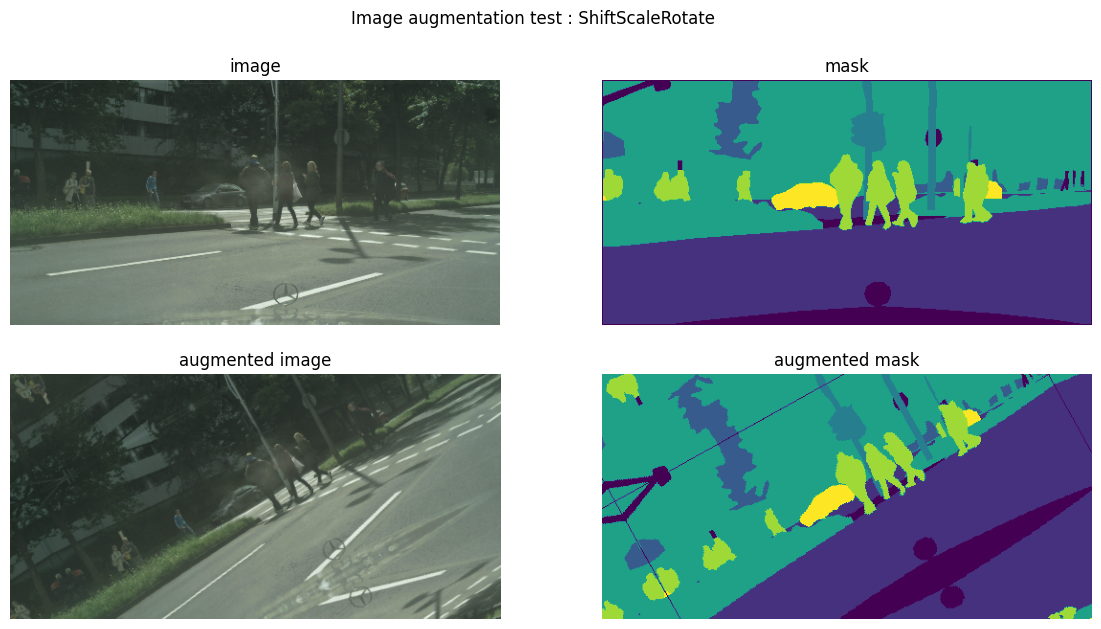

In [46]:
mf.testAlbu(
    raw_gen,
    trans=[A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=30,
        p=1,
    )],
    idx=3,
    trans_name="ShiftScaleRotate"
)

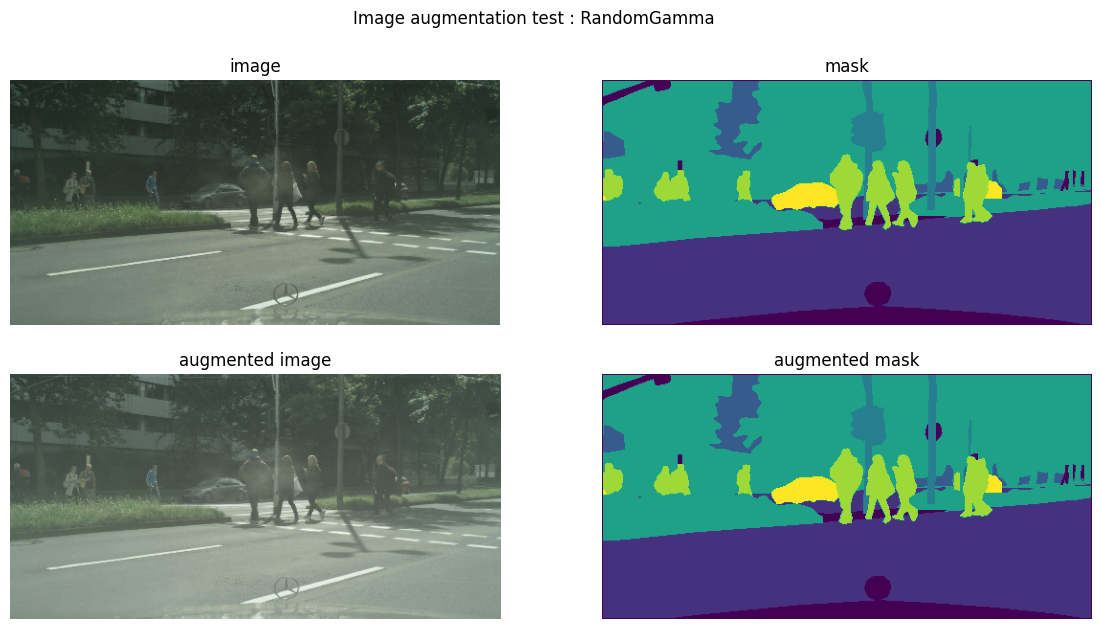

In [47]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            # A.CLAHE(p=1, clip_limit=6),
            # A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )],
    idx=3,
    trans_name="RandomGamma"
)

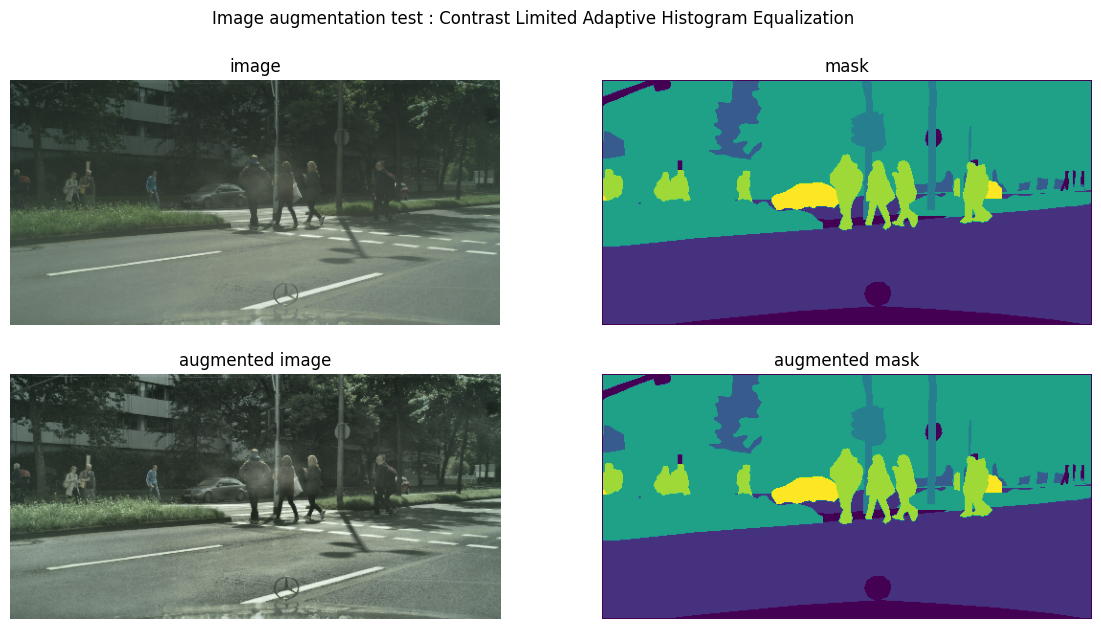

In [48]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            A.CLAHE(p=1, clip_limit=6),
            # A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            # A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )],
    idx=3,
    trans_name="Contrast Limited Adaptive Histogram Equalization"
)

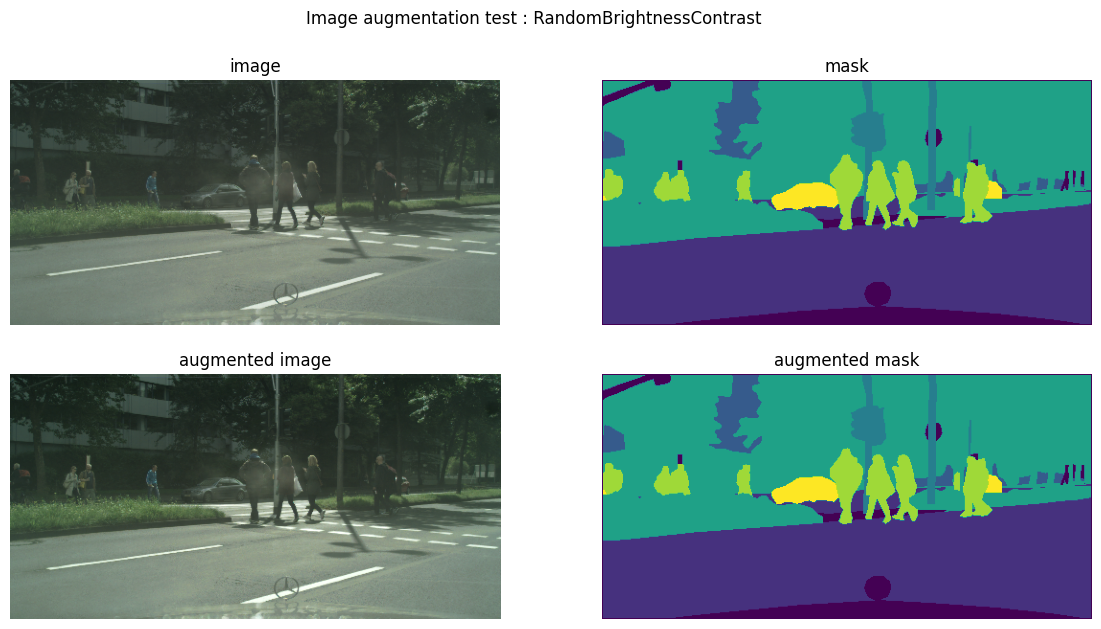

In [49]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            # A.CLAHE(p=1, clip_limit=6),
            A.RandomBrightnessContrast(p=1, brightness_limit=0.3, contrast_limit=0.3),
            # A.RandomGamma(p=1, gamma_limit=(10, 200))
        ],
        p=1
    )],
    idx=3,
    trans_name="RandomBrightnessContrast"
)

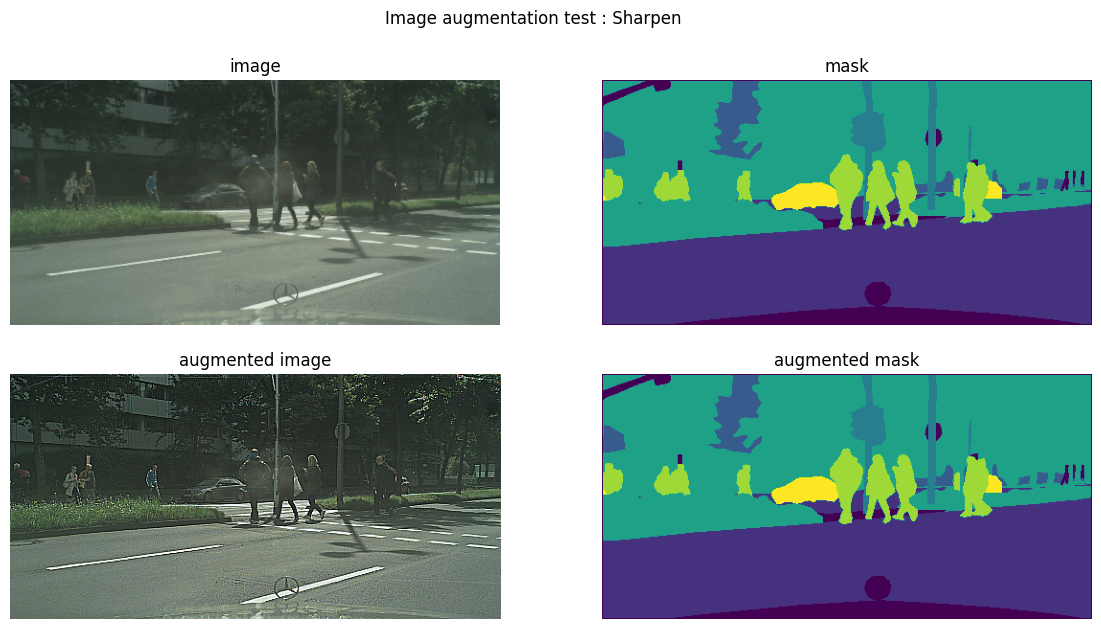

In [50]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            # A.Blur(p=1, blur_limit=9),
            # A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )],
    idx=3,
    trans_name="Sharpen"
)

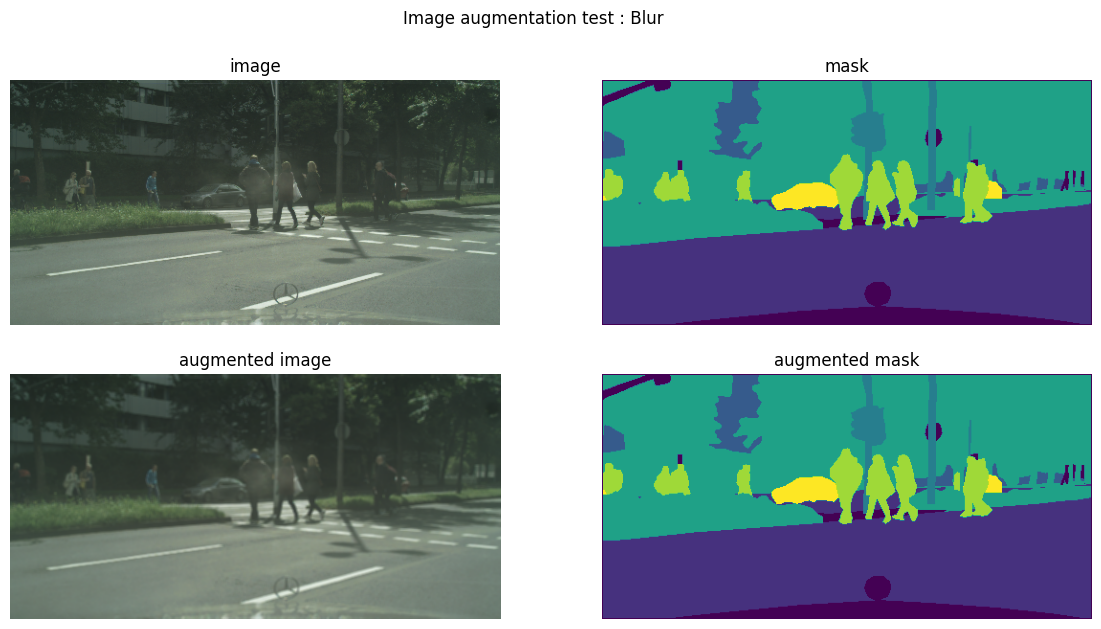

In [51]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            # A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            A.Blur(p=1, blur_limit=9),
            # A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )],
    idx=3,
    trans_name="Blur"
)

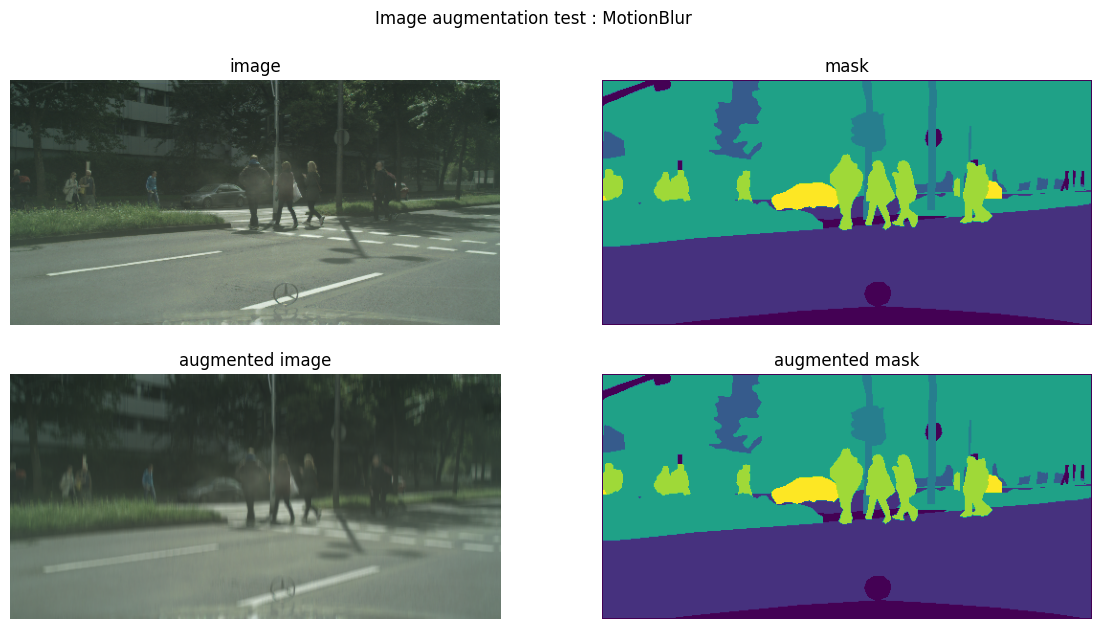

In [52]:
mf.testAlbu(
    raw_gen,
    [A.OneOf(
        [
            # A.Sharpen(p=1, alpha=(0.3,0.7), lightness=(0.5,1.0)),
            # A.Blur(p=1, blur_limit=9),
            A.MotionBlur(p=1, blur_limit=9)
        ],
        p=1
    )],
    idx=3,
    trans_name="MotionBlur"
)

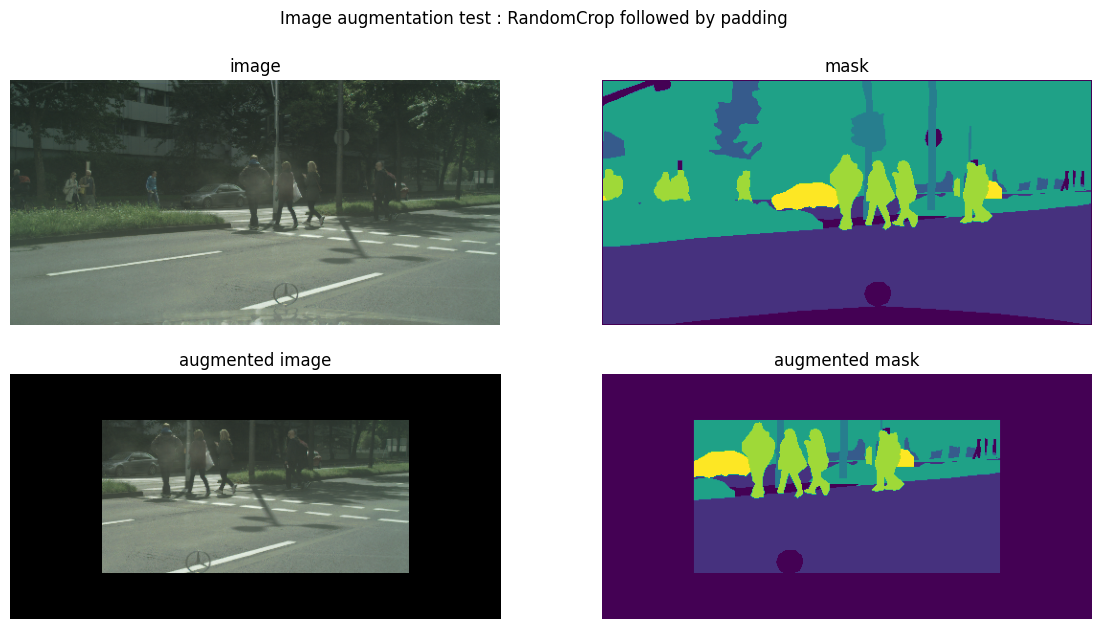

In [53]:
mf.testAlbu(
    raw_gen,
    [A.RandomCrop(
        height=160,
        width=160*2,
        p=1
    ),
    A.PadIfNeeded(
        min_height=256,
        min_width=512,
        border_mode = 0,
        p=1
    )],
    idx=3,
    trans_name="RandomCrop followed by padding"
)

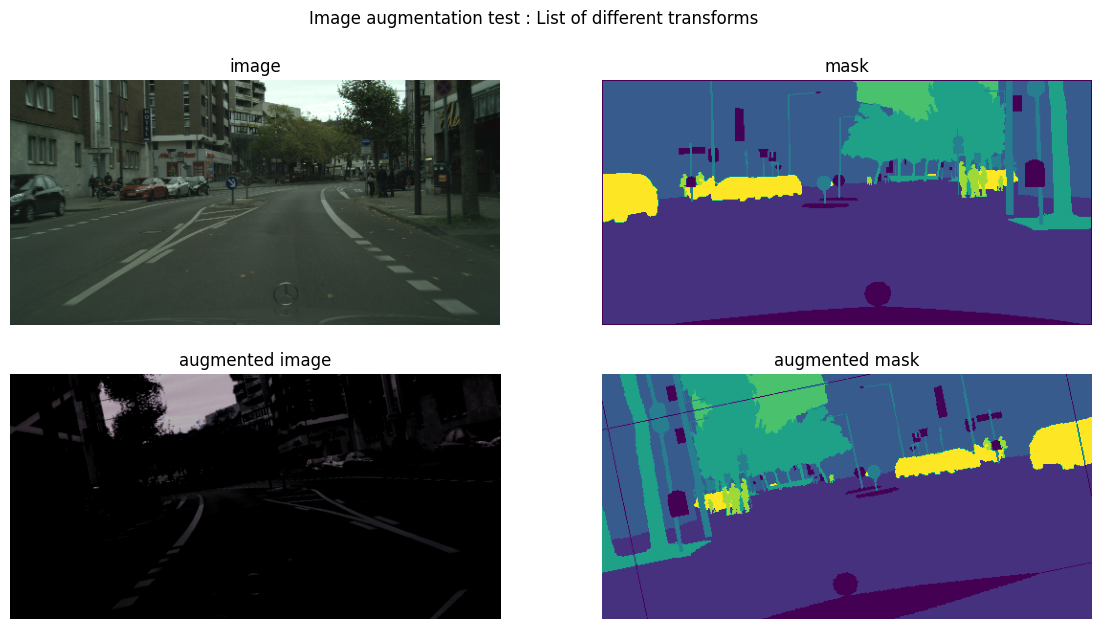

In [55]:
mf.testAlbu(raw_gen, 
         list_of_transforms, 
         idx = 1,
         trans_name="List of different transforms")